In [4]:
import pandas as pd
from geopy.geocoders import Nominatim
from ipywidgets import widgets
import folium
import numpy as np
import osmnx as ox
from osmnx import distance
import networkx as nx

df_shows = pd.read_csv('./shows.csv', sep=';', encoding='latin1')
df_parkings = pd.read_csv('./parkings.csv', sep=';', encoding='latin1')

### Point de départ

In [5]:
loc = input()
geolocator = Nominatim(user_agent="my_request")
location = geolocator.geocode(loc)

9 Rue Paul Mérindol, 84000 Avignon


### Carte avec les shows et parkings

In [6]:
map = folium.Map(location=[np.mean(df_shows['long']), np.mean(df_shows['lat'])], zoom_start=13, control_scale=True)
#Markers pour les shows en vert
for index, location_info in df_shows.iterrows():
    folium.Marker([location_info['long'], location_info['lat']], popup=location_info['title'], icon=folium.Icon(color="green")).add_to(map)
#Markers pour les parking en bleu
for index, location_info in df_parkings.iterrows():
    folium.Marker([location_info['lat'], location_info['long']], popup=location_info['name'] + '\nNombre de places: ' + location_info['nbslots']).add_to(map)
map

### Filters pour le choix de spectacles

In [8]:
titles = ["Au magasin", "Foyer des Jeunes Travailleurs", "Mon Bar", "Chapelle Saint-Louis"]
categorie = ["performance", "indiscipline", "spectacle", "danse"]
select_title = [widgets.Checkbox(value=False, description=label) for label in titles]
select_categorie = [widgets.Checkbox(value=False, description=label) for label in categorie]
select_transport = widgets.Dropdown(options=["drive", "bike", "walk"])
output1 = widgets.VBox(children=select_title)
output2 = widgets.VBox(children=select_categorie)
filters = widgets.HBox(children=[output2, output1])
display(filters, select_transport)

Dropdown(options=('drive', 'bike', 'walk'), value='drive')

In [9]:
df_show_gps = df_shows[(df_shows['type'].isin([i.description for i in output2.children if i.value == True])) & (df_shows['title'].isin([i.description for i in output1.children if i.value == True]))]

In [10]:
network_type = select_transport.value

graph_area = ("Avignon, France")
G = ox.graph_from_place(graph_area, network_type=network_type)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

### Calcul parking le plus proche

In [11]:
if(network_type=='drive'):
    show_coordinates = list(zip(df_show_gps['lat'], df_show_gps['long']))
    parking_coordinates = list(zip(df_parkings['long'], df_parkings['lat']))
    origin_nodes = []
    destination_nodes = []
    for i in show_coordinates:
        origin_nodes.append(distance.nearest_nodes(G, i[0], i[1]))
    for j in parking_coordinates:
        destination_nodes.append(distance.nearest_nodes(G, j[0], j[1]))
    distance_in_kilometers = []
    for m in origin_nodes:
        for n in destination_nodes:
            distance_in_meters = nx.shortest_path_length(G, n, m, weight='length')
            distance_in_kilometers.append(round(distance_in_meters / 1000, 2))

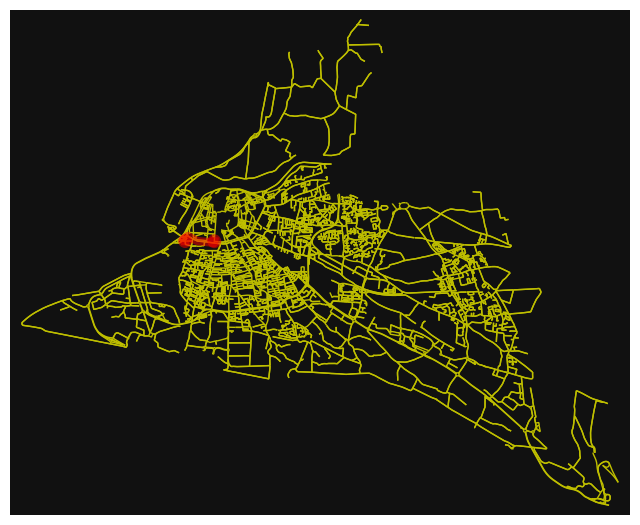

In [12]:
origin_coordinates = (location.longitude, location.latitude)
destination_coordinates = (4.805669, 43.943310)
origin_node = distance.nearest_nodes(G, origin_coordinates[0], origin_coordinates[1])
destination_node = distance.nearest_nodes(G, destination_coordinates[0], destination_coordinates[1])
shortest_route_by_distance = ox.shortest_path(G, origin_node, destination_node, weight='length')
fig, ax = ox.plot_graph_route(G, shortest_route_by_distance, edge_color='y', route_color='r', route_linewidth=6, node_size=0)

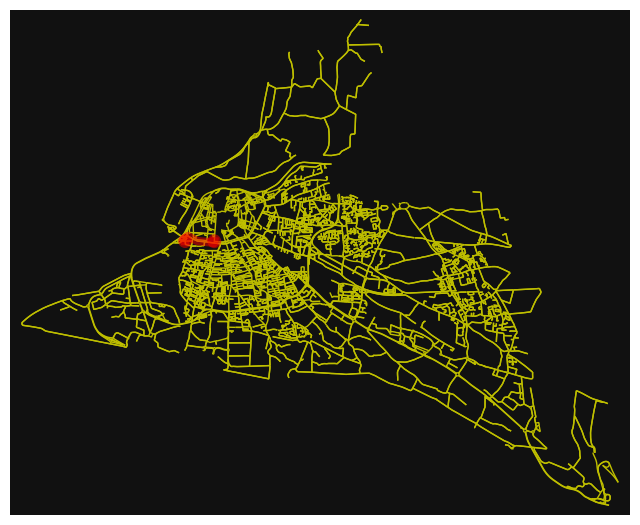

In [13]:
shortest_route_by_travel_time = ox.shortest_path(G, origin_node, destination_node, weight='length')
fig, ax = ox.plot_graph_route(G, shortest_route_by_travel_time, edge_color='y', route_color='r', route_linewidth=6, node_size=0)

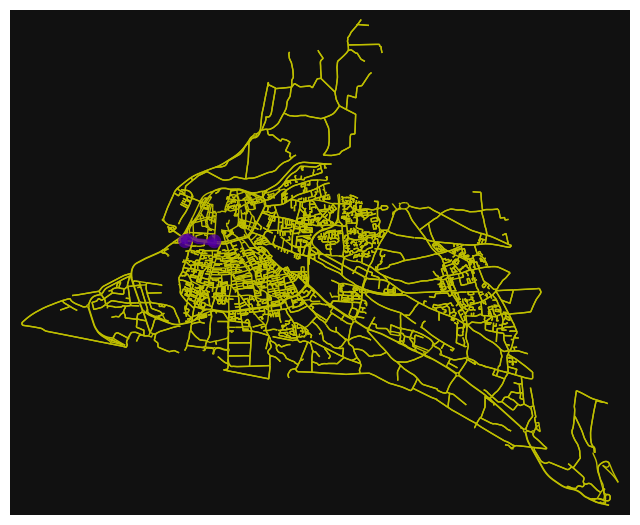

In [14]:
fig, ax = ox.plot_graph_routes(G, routes=[shortest_route_by_distance, shortest_route_by_travel_time], edge_color='y', route_colors=['r', 'b'], route_linewidth=6, node_size=0)

In [15]:
from datetime import timedelta

travel_time_in_seconds = nx.shortest_path_length(G, origin_node, destination_node, weight='travel_time')
travel_time_in_hours_minutes_seconds = str(timedelta(seconds=travel_time_in_seconds))
print(travel_time_in_hours_minutes_seconds)

0:01:07.100000


In [16]:
distance_in_meters = nx.shortest_path_length(G, origin_node, destination_node, weight='length')
distance_in_kilometers = distance_in_meters / 1000
print(distance_in_kilometers)

0.86799
